In [49]:
### 程式變數及套件初始化

# Google Colab
from google.colab import files
from google.colab import data_table

# 系統與時間設定
import os, time, locale, io
from datetime import datetime, timedelta

# 數學運算與資料處理
import math
import numpy as np
import pandas as pd

# 圖表繪製
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
import seaborn as sns

# 定義本程式的語言和時區
locale.setlocale(locale.LC_TIME, 'en_US.UTF-8')

# 定義本程式起始路徑，若已執行過會繼承上次執行的路徑
if 'homePath' not in locals():
		homePath = os.getcwd()
os.chdir(homePath)

# 以目前日期設定輸出目錄名稱，若無則創建
outFolder = os.path.join(homePath, datetime.now().strftime('output_%y%m%d'))
if not os.path.exists(outFolder):
    os.makedirs(outFolder)

# 固定參數設定
base = 'TPE'    # 目標機場
set_dpi = 144   # 繪圖解析度
file_ID = 1     # 是否輸出表單
fig_ID = 1      # 是否輸出圖

# 執行參數設定：[全, 月, 週, 日, 時]
run_ID = [1, 1, 1, 1, 1]

# 初始化完成！
print("初始化完成！")

初始化完成！


In [51]:
### 提示使用者上傳欲分析之航班總表

# 提示使用者上傳檔案
uploaded = files.upload()

# 初始化一個空的 DataFrame
df = pd.DataFrame()

# 檢查上傳的檔案
for filename in uploaded.keys():
    print(f'上傳成功！檔案名稱：{filename}, 檔案大小：{len(uploaded[filename])} bytes')

    if filename.endswith('.csv'):
        df_part = pd.read_csv(io.BytesIO(uploaded[filename]))
    elif filename.endswith('.xls') or filename.endswith('.xlsx'):
        df_part = pd.read_excel(io.BytesIO(uploaded[filename]))
    else:
        print(f'檔案格式不支援。')

    # 合併到統一的 DataFrame 中
    df = pd.concat([df, df_part], ignore_index=True)

# 調整時間日期格式
df = df.copy()
df['STD'] = pd.to_datetime(df['STD'])
df['LTD'] = pd.to_datetime(df['LTD'])
df['STA'] = pd.to_datetime(df['STA'])
df['LTA'] = pd.to_datetime(df['LTA'])
df['Best Departure Time'] = pd.to_datetime(df['Best Departure Time'])

print("已成功讀取航班總表！")

Saving 2023NOV.xls to 2023NOV.xls
上傳成功！檔案名稱：2023NOV.xls, 檔案大小：2518016 bytes
已成功讀取航班總表！


In [57]:
### 計算時段內獨立航班及航點數量

# 扣除重複航班（Irreg State 欄為 RTR 的列）
df = df[df['Irreg State'] != 'RTR']

# 定義資料時間範圍
# !!! 此處設定機場時區為 +8，未來需修改由基地（base）自動判讀。 !!!
date_start = df['STD'].min() + timedelta(0,0,0,0,0,8)
date_end = df['STD'].max() + timedelta(0,0,0,0,0,8)
print(f"資料時段: {date_start.strftime('%Y-%m-%d')} to {date_end.strftime('%Y-%m-%d')}")

# 所有航班關聯到的機場數量
all_AP = set(df['Dep'].unique()).union(df['Arr'].unique())
all_AP_df = sorted(all_AP, key=lambda x: (base not in x, x))
all_AP_df = pd.DataFrame(all_AP_df, columns=['Airport'])
num_AP = len(all_AP)

# 時間區段內執飛航線數量
all_RTE = set(df['Flight'].unique())
all_RTE_df = pd.DataFrame(sorted(all_RTE), columns=['Flight'])
num_RTE = len(all_RTE)

# 計算總航班數量
tot_FLT = len(df)

# 計算整個月所有航線載運的總乘客量
df = df.copy()
df['PAX Total'] = df['PAX flown'].apply(lambda x: int(x.split('//')[-1]) if '//' in str(x) else 0)
#df.loc[:, 'PAX Total'] = df['PAX flown'].apply(lambda x: int(x.split('//')[-1]) if '//' in str(x) else 0)
tot_PAX = df['PAX Total'].sum()

# 提取基地數據
df_base = df[df['Dep'] == base]
base_PAX = df_base['PAX Total'].sum()

# 顯示結果
print(f"\n=== 所有場站資料 ===")
print(f"執飛航點數量: {num_AP}")
print(f"執飛航線數量: {num_RTE}")
print(f"執飛航班數量: {tot_FLT}")
print(f"載運乘客總量: {tot_PAX}")
print(f"\n=== {base} 機場資料 ===")
print(f"{base} 離場航班數量: {len(df_base)}")
print(f"{base} 離境旅客人次: {base_PAX}")

資料時段: 2023-11-01 to 2023-11-30

=== 所有場站資料 ===
執飛航點數量: 21
執飛航線數量: 60
執飛航班數量: 1340
載運乘客總量: 244597

=== TPE 機場資料 ===
TPE 離場航班數量: 670
TPE 離境旅客人次: 123058


In [58]:
### 航班準時率分析函數定義

# 設定延誤門檻（超過即視為延誤）
DT_th = timedelta(0,0,0,0,15,0)		# 15 分鐘
DT_th_min = int(DT_th.total_seconds() // 60)

def otp_calc(df_intrest, otp_type):

    # 資料時間範圍
    sub_start = pd.to_datetime(df_intrest['LTD']).min()
    sub_end = pd.to_datetime(df_intrest['LTD']).max()

    # 資料篩選分類
    if otp_type == 0:
        file_key = 'Overall'
        print(f"{base} 延誤狀況統整")
        print(f"（延誤 {DT_th_min} 分鐘以上者計之）\n")
        #print(f"\n=== 全時段 ===")
    elif otp_type == 4:
        file_key = 'Hour'
        sub_start = pd.to_datetime(df_intrest['LTD']).min().hour
        #print(f"\n=== {sub_start}:00 to {sub_start + 1}:00 ===")
    elif otp_type == 3:
        file_key = 'Day'
        #print(f"\n=== {sub_start.strftime('%Y-%m-%d')} ===")
    elif otp_type == 2:
        file_key = 'Week'
        #print(f"\n=== {sub_start.strftime('%YW%U')} ===")
    elif otp_type == 1:
        file_key = 'Month'
        #print(f"\n=== {sub_start.strftime('%Y-%m')} ===")
    else:
        file_key = 'Any'
        #print(f"\n=== {sub_start.strftime('%Y-%m-%d')} to {sub_end.strftime('%Y-%m-%d')}")

    # 調整時間日期格式以利運算
    df_intrest = df_intrest.copy()
    df_intrest['Best Departure Time'] = pd.to_datetime(df_intrest['Best Departure Time'])
    df_intrest['STD'] = pd.to_datetime(df_intrest['STD'])

    # 有延誤起飛的航班
    DLY = df_intrest[df_intrest['Best Departure Time'] - df_intrest['STD'] > DT_th]
    DLYT_ttl = (DLY['Best Departure Time'] - DLY['STD']).sum()
    DLYT_ttl = DLYT_ttl.total_seconds() / 3600
    DLYT_ttl = round(DLYT_ttl, 2)
    DLYT_avg = DLY['Best Departure Time'].sub(DLY['STD']).mean()
    DLYT_avg = DLYT_avg.total_seconds() / 60
    DLYT_avg = round(DLYT_avg, 1)
    if math.isnan(DLYT_avg):
        DLYT_avg = 0
    num_DLY = len(DLY)
    DLYP_ttl = DLY['PAX Total'].sum()

    # 顯示結果
    if otp_type == 0:
        print(f"延誤起飛航班數量: {num_DLY} ({round(100*num_DLY/len(df_intrest), 2)}%)")
        print(f"平均每航班延誤 {DLYT_avg} 分鐘")
        print(f"全日期區間總延誤 {DLYT_ttl} 小時")
        print(f"受影響乘客共 {DLYP_ttl} 人次")

    # 回傳準點率
    OTP = round(100*(1 - num_DLY/len(df_intrest)), 2)

#    return OTP
    return OTP, num_DLY, DLYP_ttl

In [62]:
### 航班時段準時率分析（全時段）

if run_ID[0] == 1:

    # 全日期區間準時率分析
    OT_overall = pd.DataFrame({'Period': ['Overall'], 'OTP': [np.nan], 'TTL FLT': [0], 'DLY FLT': [0], 'DLY PAX': [0]})
    OT_overall.at[0, 'TTL FLT'] = round(len(df_base))
    OT_overall.at[0, 'OTP'], OT_overall.at[0, 'DLY FLT'], OT_overall.at[0, 'DLY PAX'] = otp_calc(df_base, 0)

    # 輸出準時率表單
    if file_ID == 1:
        save_path = os.path.join(outFolder, f"{base}_OTP-Overall_{date_start.strftime('%Y%m%d')}-{date_end.strftime('%Y%m%d')}.csv")
        OT_overall.to_csv(save_path, index=False)
        print(f"\n全時段準時率表單輸出完成！\n")

    # 顯示統計表
    print(OT_overall)

else:
    print('未執行。')

TPE 延誤狀況統整
（延誤 15 分鐘以上者計之）

延誤起飛航班數量: 122 (18.21%)
平均每航班延誤 29.8 分鐘
全日期區間總延誤 60.6 小時
受影響乘客共 24171 人次

全時段準時率表單輸出完成！

    Period    OTP  TTL FLT  DLY FLT  DLY PAX
0  Overall  81.79      670      122    24171



每小時準時率表單輸出完成！

   Period     OTP  TTL FLT  DLY FLT  DLY PAX
0     00H     NaN        0        0        0
1     01H     NaN        0        0        0
2     02H     NaN        0        0        0
3     03H     NaN        0        0        0
4     04H     NaN        0        0        0
5     05H     NaN        0        0        0
6     06H   58.33       48       20     3417
7     07H   61.18       85       33     5813
8     08H   71.43       42       12     2580
9     09H   80.00      120       24     5110
10    10H   84.42       77       12     3187
11    11H   95.31       64        3      476
12    12H   98.51       67        1      163
13    13H     NaN        0        0        0
14    14H   95.83       48        2      341
15    15H   89.83       59        6     1115
16    16H     NaN        0        0        0
17    17H  100.00       30        0        0
18    18H     NaN        0        0        0
19    19H     NaN        0        0        0
20    20H     NaN        0        0    

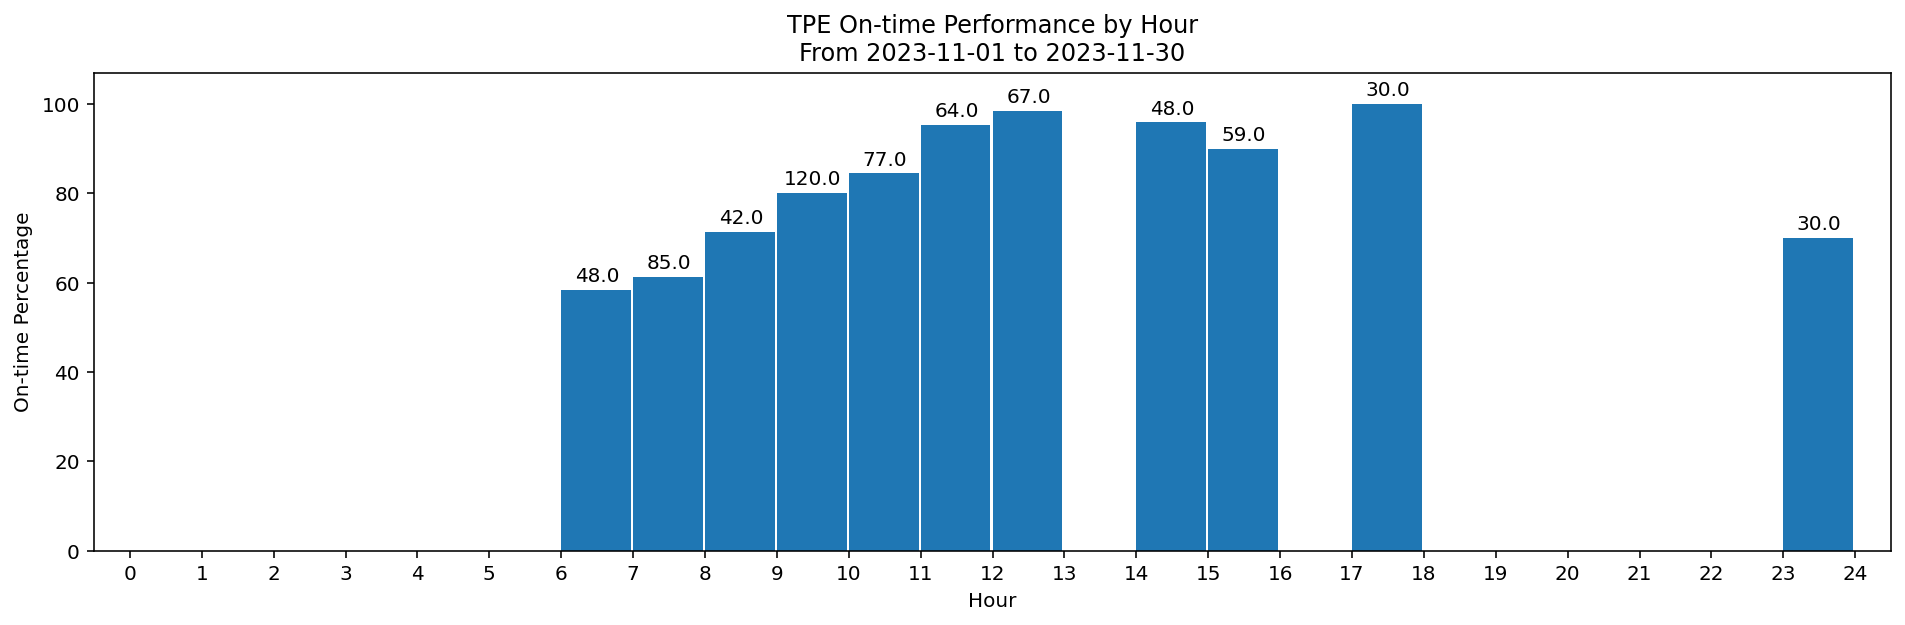

In [80]:
### 航班時段準時率分析（每時）

if run_ID[4] == 1:

    # 每小時準時率分析
    unique_hours = df['LTD'].dt.hour.unique().tolist()
    OT_hour = pd.DataFrame({'Period': list(range(24)), 'OTP': np.nan, 'TTL FLT': [0]*24, 'DLY FLT': [0]*24, 'DLY PAX': [0]*24})
    for hour in unique_hours:
        hour_str = str(hour).zfill(2)
        hour_end_str = str(hour+1).zfill(2)
        start_T = datetime.strptime(f'{hour_str}:00', '%H:%M').time()
        end_T = datetime.strptime(f'{hour_str}:59', '%H:%M').time()
        df_base_hour = df_base[(df_base['LTD'].dt.time >= start_T) & (df_base['LTD'].dt.time <= end_T)]
        OT_hour.at[hour, 'TTL FLT'] = round(len(df_base_hour))
        if len(df_base_hour) > 0:
            OT_hour.at[hour, 'OTP'], OT_hour.at[hour, 'DLY FLT'], OT_hour.at[hour, 'DLY PAX'] = otp_calc(df_base_hour, 4)

    # 篩選出有效資料
    valid_OT_hour = OT_hour[pd.notna(OT_hour['OTP'])]

    # 輸出準時率表單
    OT_hour['Period'] = OT_hour['Period'].apply(lambda x: '{:02d}H'.format(x))
    if file_ID == 1:
        save_path = os.path.join(outFolder, f"{base}_OTP-Hour_{date_start.strftime('%Y%m%d')}-{date_end.strftime('%Y%m%d')}.csv")
        OT_hour.to_csv(save_path, index=False)
        print(f"\n每小時準時率表單輸出完成！\n")

    # 顯示統計表
    print(OT_hour)

    # 圖面初始化
    plt.figure(figsize=(1920/set_dpi, 640/set_dpi), dpi=set_dpi)
    plt.title(f"{base} On-time Performance by Hour\nFrom {date_start.strftime('%Y-%m-%d')} to {date_end.strftime('%Y-%m-%d')}")

    # 繪製直方圖
    plt.bar(valid_OT_hour['Period'], valid_OT_hour['OTP'], width=0.97, align='edge', label=None)

    # 註記航班數量
    for i, row in valid_OT_hour.iterrows():
        plt.text(row['Period'] + 0.5, row['OTP'] + 1, f"{row['TTL FLT']}", ha='center', va='bottom')

    # 圖面呈現設置
    plt.xlabel('Hour')
    plt.ylabel('On-time Percentage')
    plt.xlim([-0.5, 24.5])
    plt.ylim([0, 107])
    plt.xticks(np.arange(0, 25, 1))
    plt.tight_layout()
    if fig_ID == 1:
        plt.savefig(os.path.join(outFolder, f"{base}_OTP-Hour_{date_start.strftime('%Y%m%d')}-{date_end.strftime('%Y%m%d')}.jpg"))
        print(f"\n每小時準時率統計圖輸出完成！\n")
    plt.show()

else:
     print('未執行。')


每日準時率表單輸出完成！

        Period    OTP  TTL FLT  DLY FLT  DLY PAX
0   2023-11-01  72.73       22        6     1195
1   2023-11-02  82.61       23        4      795
2   2023-11-03  90.48       21        2      320
3   2023-11-04  80.95       21        4      824
4   2023-11-05  86.36       22        3      698
5   2023-11-06  90.91       22        2      285
6   2023-11-07  77.27       22        5      998
7   2023-11-08  80.95       21        4      775
8   2023-11-09  60.87       23        9     1679
9   2023-11-10  94.74       19        1      182
10  2023-11-11  77.27       22        5     1022
11  2023-11-12  95.24       21        1      190
12  2023-11-13  87.50       24        3      622
13  2023-11-14  75.00       20        5     1076
14  2023-11-15  52.17       23       11     2091
15  2023-11-16  91.30       23        2      455
16  2023-11-17  73.91       23        6     1374
17  2023-11-18  68.18       22        7     1369
18  2023-11-19  91.30       23        2      348
19  2

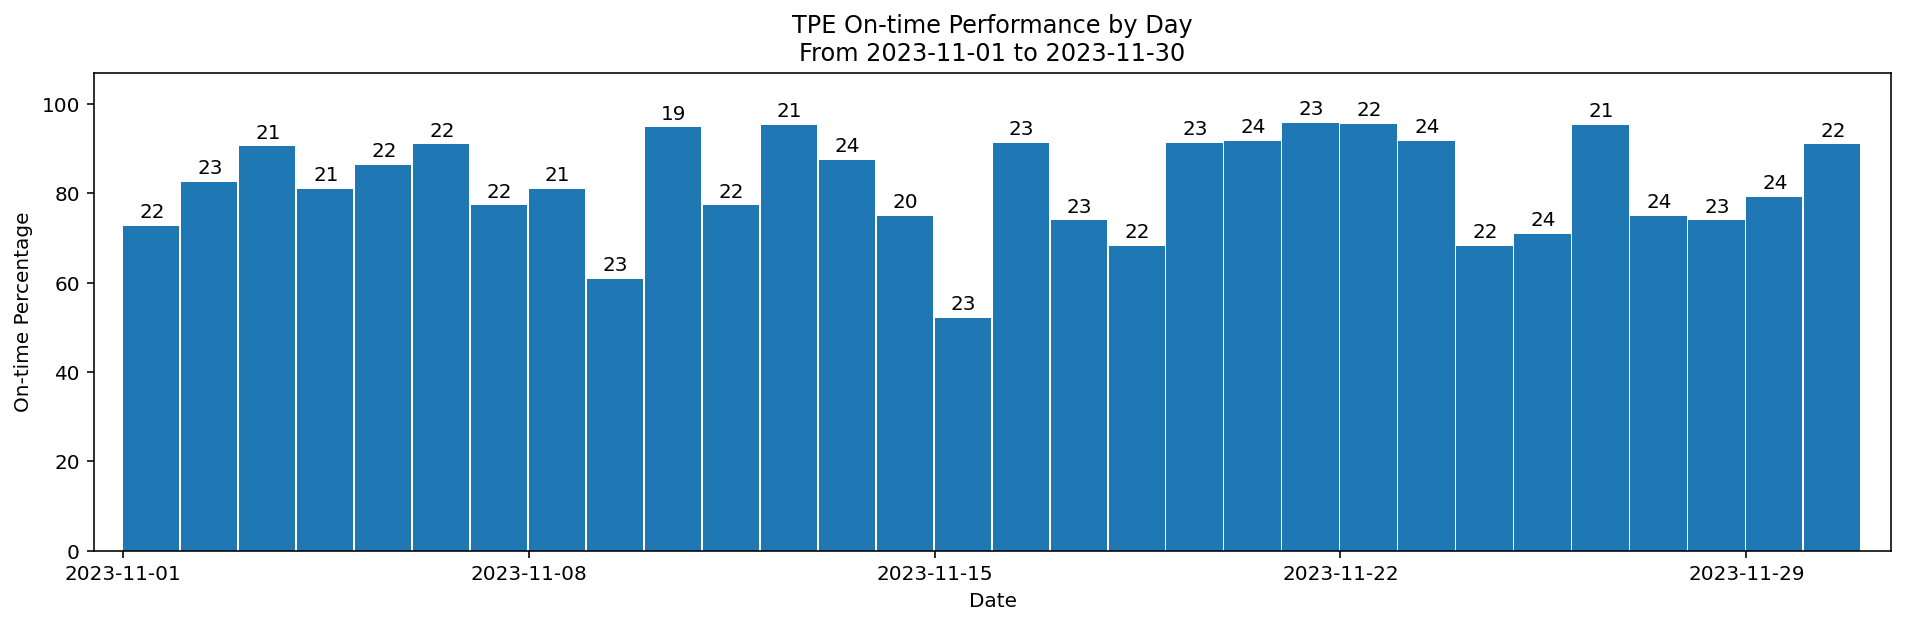

In [81]:
### 航班時段準時率分析（每日）

if run_ID[3] == 1:

    # 每日準時率分析
    unique_dates = df['LTD'].dt.date.unique().tolist()
    OT_day = pd.DataFrame({'Period': unique_dates, 'OTP': np.nan, 'TTL FLT': [0]*len(unique_dates), 'DLY FLT': [0]*len(unique_dates), 'DLY PAX': [0]*len(unique_dates)})
    for idx, day in enumerate(unique_dates):
        df_base_day = df_base[df_base['LTD'].dt.date == day]
        OT_day.at[idx, 'TTL FLT'] = round(len(df_base_day))
        if len(df_base_day) > 0:
            OT_day.at[idx, 'OTP'], OT_day.at[idx, 'DLY FLT'], OT_day.at[idx, 'DLY PAX'] = otp_calc(df_base_day, 3)

    # 輸出準時率表單
    if file_ID == 1:
        save_path = os.path.join(outFolder, f"{base}_OTP-Day_{date_start.strftime('%Y%m%d')}-{date_end.strftime('%Y%m%d')}.csv")
        OT_day.to_csv(save_path, index=False)
        print(f"\n每日準時率表單輸出完成！\n")

    # 顯示統計表
    print(OT_day)

    # 篩選出有效資料
    valid_OT_day = OT_day[pd.notna(OT_day['OTP'])]

    # 圖面初始化
    plt.figure(figsize=(1920/set_dpi, 640/set_dpi), dpi=set_dpi)
    plt.title(f"{base} On-time Performance by Day\nFrom {date_start.strftime('%Y-%m-%d')} to {date_end.strftime('%Y-%m-%d')}")

    # 繪製直方圖
    plt.bar(valid_OT_day['Period'], valid_OT_day['OTP'], width=0.97, align='edge', label=None)

    # 註記航班數量
    for i, row in valid_OT_day.iterrows():
        plt.text(date2num(row['Period']) + 0.5, row['OTP'] + 1, f"{row['TTL FLT']}", ha='center', va='bottom')

    # 圖面呈現設置
    plt.xlabel('Date')
    plt.ylabel('On-time Percentage')
    plt.xlim([date2num(valid_OT_day['Period'].min()) - 0.5, date2num(valid_OT_day['Period'].max()) + 1.5])
    plt.ylim([0, 107])
    plt.xticks(np.arange(date2num(valid_OT_day['Period'].min()), date2num(valid_OT_day['Period'].max()) + 1, 7))
    plt.tight_layout()
    if fig_ID == 1:
        plt.savefig(os.path.join(outFolder, f"{base}_OTP-Day_{date_start.strftime('%Y%m%d')}-{date_end.strftime('%Y%m%d')}.jpg"))
        print(f"\n每日準時率統計圖輸出完成！\n")
    plt.show()

else:
     print('未執行。')


每週準時率表單輸出完成！

    Period    OTP  TTL FLT  DLY FLT  DLY PAX
0  2023W44  81.61       87       16     3134
1  2023W45  80.79      151       29     5639
2  2023W46  77.56      156       35     7177
3  2023W47  86.42      162       22     4385
4  2023W48  82.46      114       20     3836

每週準時率統計圖輸出完成！



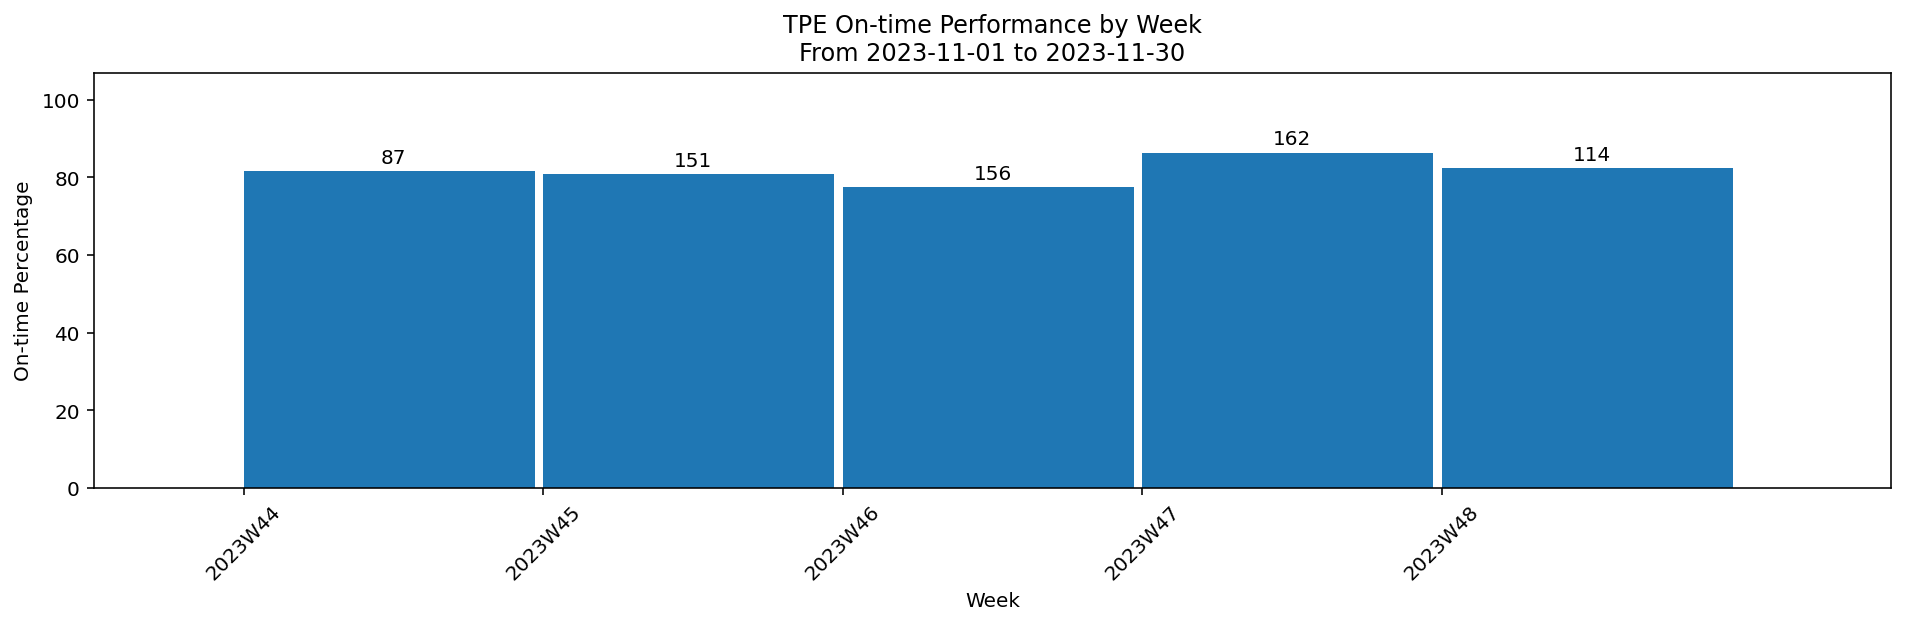

In [82]:
### 航班時段準時率分析（每週）

if run_ID[2] == 1:

    # 每日準時率分析
    unique_week = df['LTD'].dt.to_period('W-SAT').unique().tolist()
    OT_week = pd.DataFrame({'Period': unique_week, 'OTP': np.nan, 'TTL FLT': [0]*len(unique_week), 'DLY FLT': [0]*len(unique_week), 'DLY PAX': [0]*len(unique_week)})
    for idx, week in enumerate(unique_week):
        df_base_week = df_base[df_base['LTD'].dt.to_period('W-SAT') == week]
        OT_week.at[idx, 'TTL FLT'] = round(len(df_base_week))
        if len(df_base_week) > 0:
            OT_week.at[idx, 'OTP'], OT_week.at[idx, 'DLY FLT'], OT_week.at[idx, 'DLY PAX'] = otp_calc(df_base_week, 2)

    # 篩選出有效資料
    valid_OT_week = OT_week[pd.notna(OT_week['OTP'])]
    #valid_OT_week_str = valid_OT_week['Week'].dt.weekofyear.astype(str)
    valid_OT_week_str = valid_OT_week['Period'].dt.strftime('%YW%U')
    OT_week['Period'] = OT_week['Period'].dt.strftime('%YW%U')

    # 輸出準時率表單
    if file_ID == 1:
        save_path = os.path.join(outFolder, f"{base}_OTP-Week_{date_start.strftime('%Y%m%d')}-{date_end.strftime('%Y%m%d')}.csv")
        OT_week.to_csv(save_path, index=False)
        print(f"\n每週準時率表單輸出完成！\n")

    # 顯示統計表
    print(OT_week)

    # 圖面初始化
    plt.figure(figsize=(1920/set_dpi, 640/set_dpi), dpi=set_dpi)
    plt.title(f"{base} On-time Performance by Week\nFrom {date_start.strftime('%Y-%m-%d')} to {date_end.strftime('%Y-%m-%d')}")

    # 繪製直方圖
    plt.bar(date2num(valid_OT_week['Period']), valid_OT_week['OTP'], width=6.8, align='edge', label=None)

    # 註記航班數量
    for i, row in valid_OT_week.iterrows():
        plt.text(date2num(valid_OT_week['Period'])[i] + 3.5, row['OTP'] + 1, f"{row['TTL FLT']}", ha='center', va='bottom')

    # 設定刻度
    tick_pos = np.arange(date2num(valid_OT_week['Period'].min()), date2num(valid_OT_week['Period'].max()) + 1, 7)

    # 圖面呈現設置
    plt.xlabel('Week')
    plt.ylabel('On-time Percentage')
    plt.xlim([date2num(valid_OT_week['Period'].min()) - 3.5, date2num(valid_OT_week['Period'].max()) + 10.5])
    plt.ylim([0, 107])
    plt.xticks(tick_pos, valid_OT_week_str, rotation=45)
    plt.tight_layout()
    if fig_ID == 1:
        plt.savefig(os.path.join(outFolder, f"{base}_OTP-Week_{date_start.strftime('%Y%m%d')}-{date_end.strftime('%Y%m%d')}.jpg"))
        print(f"\n每週準時率統計圖輸出完成！\n")
    plt.show()

else:
     print('未執行。')


每月準時率表單輸出完成！

    Period    OTP  TTL FLT  DLY FLT  DLY PAX
0  2023-11  81.79      670      122    24171

每月準時率統計圖輸出完成！



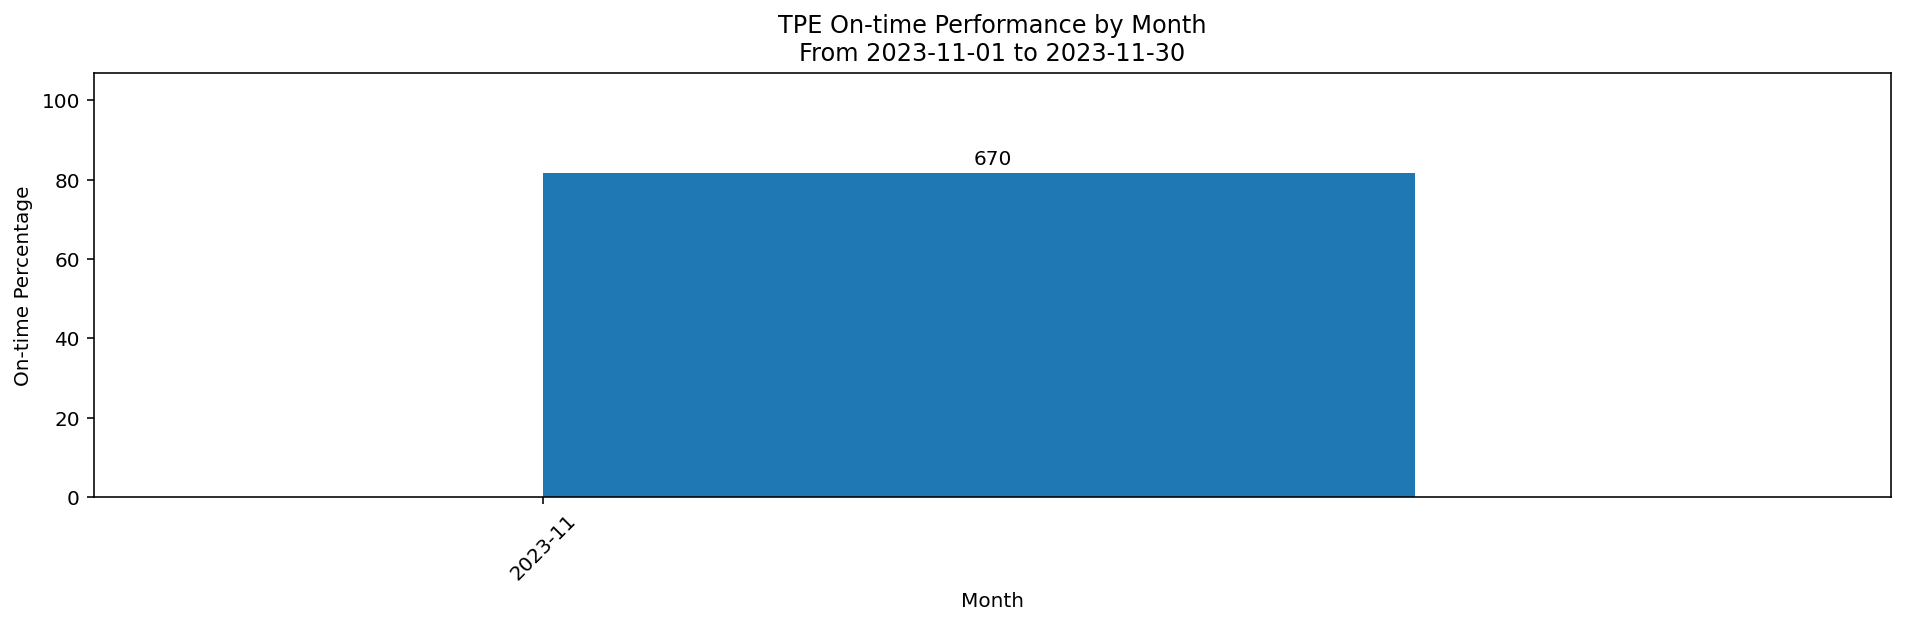

In [83]:
### 航班時段準時率分析（每月）

if run_ID[1] == 1:

    # 每日準時率分析
    unique_month = df['LTD'].dt.to_period('M').unique().tolist()
    OT_month = pd.DataFrame({'Period': unique_month, 'OTP': np.nan, 'TTL FLT': [0]*len(unique_month), 'DLY FLT': [0]*len(unique_month), 'DLY PAX': [0]*len(unique_month)})
    for idx, month in enumerate(unique_month):
        df_base_month = df_base[df_base['LTD'].dt.to_period('M') == month]
        OT_month.at[idx, 'TTL FLT'] = round(len(df_base_month))
        if len(df_base_month) > 0:
            OT_month.at[idx, 'OTP'], OT_month.at[idx, 'DLY FLT'], OT_month.at[idx, 'DLY PAX'] = otp_calc(df_base_month, 1)

    # 輸出準時率表單
    if file_ID == 1:
        save_path = os.path.join(outFolder, f"{base}_OTP-Month_{date_start.strftime('%Y%m%d')}-{date_end.strftime('%Y%m%d')}.csv")
        OT_month.to_csv(save_path, index=False)
        print(f"\n每月準時率表單輸出完成！\n")

    # 顯示統計表
    print(OT_month)

    # 篩選出有效資料
    valid_OT_month = OT_month[pd.notna(OT_month['OTP'])]
    valid_OT_month_str = valid_OT_month['Period'].astype(str)

    # 圖面初始化
    plt.figure(figsize=(1920/set_dpi, 640/set_dpi), dpi=set_dpi)
    plt.title(f"{base} On-time Performance by Month\nFrom {date_start.strftime('%Y-%m-%d')} to {date_end.strftime('%Y-%m-%d')}")

    # 繪製直方圖
    plt.bar(date2num(valid_OT_month['Period']), valid_OT_month['OTP'], width=0.97, align='edge', label=None)

    # 註記航班數量
    for i, row in valid_OT_month.iterrows():
        plt.text(date2num(valid_OT_month['Period'])[i] + 0.5, row['OTP'] + 1, f"{row['TTL FLT']}", ha='center', va='bottom')

    # 設定刻度
    tick_pos = np.arange(date2num(valid_OT_month['Period'].min()), date2num(valid_OT_month['Period'].max()) + 1, 1)

    # 圖面呈現設置
    plt.xlabel('Month')
    plt.ylabel('On-time Percentage')
    plt.xlim([date2num(valid_OT_month['Period'].min()) - 0.5, date2num(valid_OT_month['Period'].max()) + 1.5])
    plt.ylim([0, 107])
    plt.xticks(tick_pos, valid_OT_month_str, rotation=45)
    plt.tight_layout()
    if fig_ID == 1:
        plt.savefig(os.path.join(outFolder, f"{base}_OTP-Month_{date_start.strftime('%Y%m%d')}-{date_end.strftime('%Y%m%d')}.jpg"))
        print(f"\n每月準時率統計圖輸出完成！\n")
    plt.show()

else:
     print('未執行。')